<a href="https://colab.research.google.com/github/MPGarg/Assignment-10/blob/main/EVA8_Assigment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
#from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import files from GIT Hub

In [ ]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 112 (delta 26), reused 46 (delta 21), pack-reused 52
Receiving objects: 100% (112/112), 42.07 KiB | 3.24 MiB/s, done.
Resolving deltas: 100% (46/46), done.


# ViT class is imported

In [ ]:
from main_repo.models import vit
from main_repo.models.vit import ViT

# Import Other fuctions

In [ ]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
view_model = ViT(img_size=32,in_channels=3,patch_size=16,num_transformer_layers=8,embedding_dim=768,mlp_size=3072,num_heads=4,num_classes=10).to(device)
summary(model=view_model, 
        input_size=(32, 3, 32, 32), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 32, 32]      [32, 10]             4,608                True
├─PatchEmbedding (patch_embedding)                           [32, 3, 32, 32]      [32, 4, 768]         --                   True
│    └─Conv2d (patcher)                                      [32, 3, 32, 32]      [32, 768, 2, 2]      590,592              True
│    └─Flatten (flatten)                                     [32, 768, 2, 2]      [32, 768, 4]         --                   --
├─Dropout (embedding_dropout)                                [32, 5, 768]         [32, 5, 768]         --                   --
├─Sequential (transformer_encoder)                           [32, 5, 768]         [32, 5, 768]         --                   True
│    └─TransformerEncoderBlock (0)                           [32, 5, 768]         [32, 5, 768]  

# Show sample images and Load dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 70330369.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


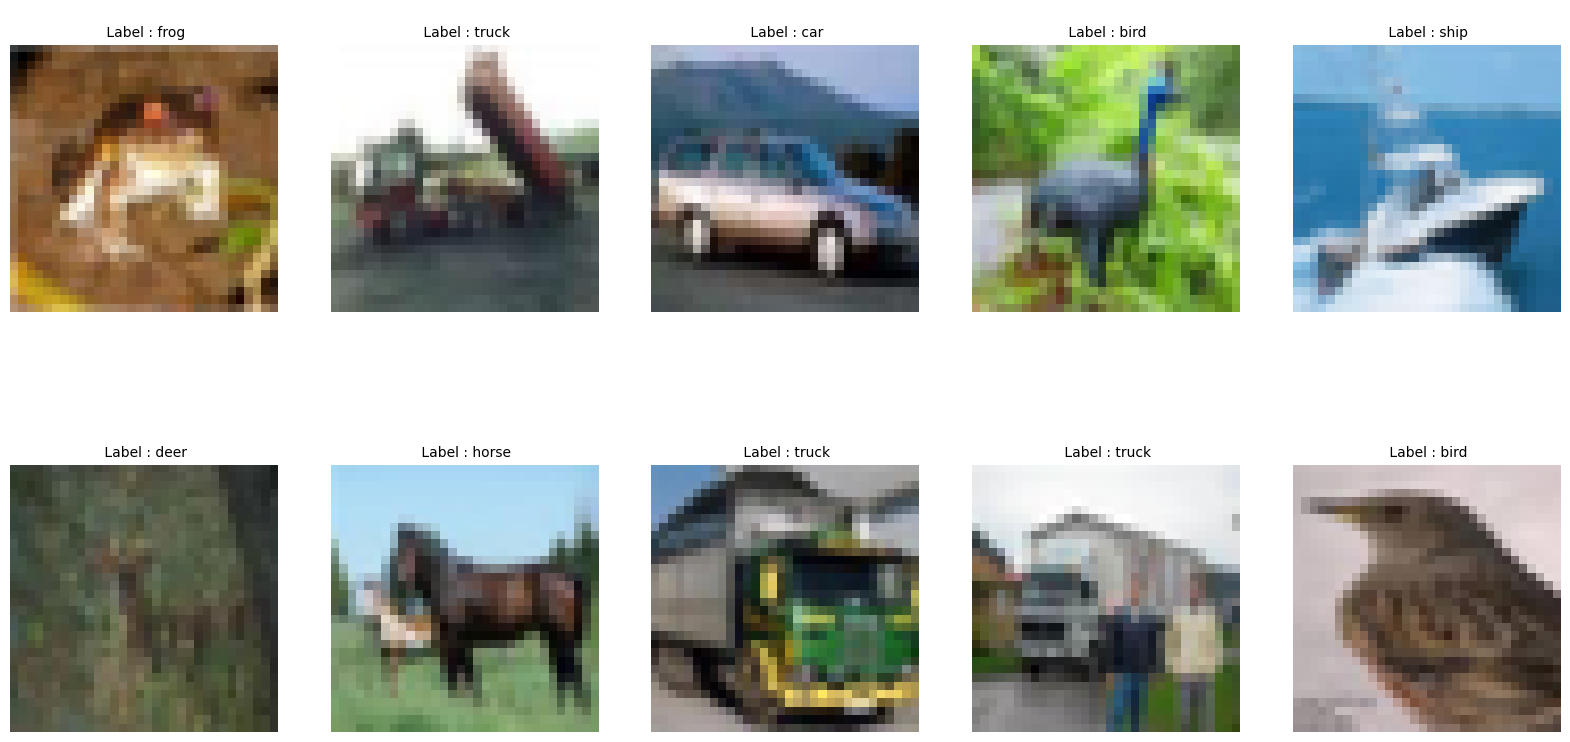

In [ ]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std,trainset_lr,trainloader_lr = process_dataset(visualize = 'X')     

# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.23E-01


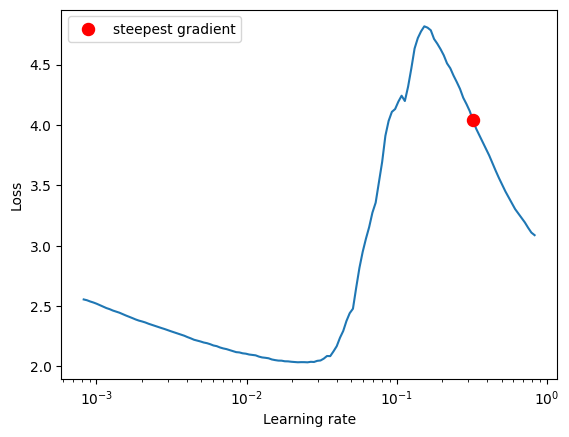

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.32261762664155014)

In [48]:
import copy
model = ViT(img_size=32,in_channels=3,patch_size=16,num_transformer_layers=8,embedding_dim=768,mlp_size=3072,num_heads=4,num_classes=10).to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.0005, momentum=0.9,weight_decay=0.02)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_lr, end_lr=10, num_iter=200)
lr_finder.plot() 

In [49]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.025492596558974765


# Train & Test Model

In [ ]:
ler_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9,weight_decay=0.02)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.5,
                                                div_factor=10,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0001)


100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


Average Training Loss=0.004488227200508118, Accuracy=14.022


Test set: Average loss: 0.0043, Accuracy: 2154/10000 (21.54%)

EPOCH: 2 (LR: 0.00017506382978723403)


100%|██████████| 98/98 [00:31<00:00,  3.07it/s]


Average Training Loss=0.004212397027015686, Accuracy=21.738


Test set: Average loss: 0.0041, Accuracy: 2807/10000 (28.07%)

EPOCH: 3 (LR: 0.00025012765957446807)


100%|██████████| 98/98 [00:31<00:00,  3.15it/s]


Average Training Loss=0.004035373013019562, Accuracy=24.91


Test set: Average loss: 0.0039, Accuracy: 3011/10000 (30.11%)

EPOCH: 4 (LR: 0.0003251914893617021)


100%|██████████| 98/98 [00:31<00:00,  3.10it/s]


Average Training Loss=0.003909878432750702, Accuracy=27.852


Test set: Average loss: 0.0038, Accuracy: 3116/10000 (31.16%)

EPOCH: 5 (LR: 0.00040025531914893614)


100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Average Training Loss=0.0038368970108032226, Accuracy=29.472


Test set: Average loss: 0.0038, Accuracy: 3272/10000 (32.72%)

EPOCH: 6 (LR: 0.0004753191489361702)


100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


Average Training Loss=0.003775283064842224, Accuracy=30.766


Test set: Average loss: 0.0037, Accuracy: 3408/10000 (34.08%)

EPOCH: 7 (LR: 0.0005503829787234043)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.003725121743679047, Accuracy=32.014


Test set: Average loss: 0.0037, Accuracy: 3382/10000 (33.82%)

EPOCH: 8 (LR: 0.0006254468085106383)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.003683230063915253, Accuracy=32.708


Test set: Average loss: 0.0036, Accuracy: 3466/10000 (34.66%)

EPOCH: 9 (LR: 0.0007005106382978723)


100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


Average Training Loss=0.0036469050574302673, Accuracy=33.246


Test set: Average loss: 0.0036, Accuracy: 3550/10000 (35.50%)

EPOCH: 10 (LR: 0.0007755744680851064)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.0036239260244369507, Accuracy=33.636


Test set: Average loss: 0.0036, Accuracy: 3611/10000 (36.11%)

EPOCH: 11 (LR: 0.0008506382978723404)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.0035911576175689697, Accuracy=34.486


Test set: Average loss: 0.0036, Accuracy: 3588/10000 (35.88%)

EPOCH: 12 (LR: 0.0009257021276595745)


100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Average Training Loss=0.003565920293331146, Accuracy=34.946


Test set: Average loss: 0.0035, Accuracy: 3692/10000 (36.92%)

EPOCH: 13 (LR: 0.0009991496683673469)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.0035421187710762024, Accuracy=35.304


Test set: Average loss: 0.0035, Accuracy: 3778/10000 (37.78%)

EPOCH: 14 (LR: 0.000915817168367347)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.00352161092042923, Accuracy=35.594


Test set: Average loss: 0.0035, Accuracy: 3760/10000 (37.60%)

EPOCH: 15 (LR: 0.000832484668367347)


100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Average Training Loss=0.0035120862913131713, Accuracy=35.804


Test set: Average loss: 0.0035, Accuracy: 3826/10000 (38.26%)

EPOCH: 16 (LR: 0.000749152168367347)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.003490486249923706, Accuracy=36.036


Test set: Average loss: 0.0035, Accuracy: 3800/10000 (38.00%)

EPOCH: 17 (LR: 0.0006658196683673469)


100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


Average Training Loss=0.0034815284729003905, Accuracy=36.44


Test set: Average loss: 0.0035, Accuracy: 3854/10000 (38.54%)

EPOCH: 18 (LR: 0.000582487168367347)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.003467408127784729, Accuracy=36.576


Test set: Average loss: 0.0035, Accuracy: 3811/10000 (38.11%)

EPOCH: 19 (LR: 0.0004991546683673468)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.003456737563610077, Accuracy=36.834


Test set: Average loss: 0.0035, Accuracy: 3847/10000 (38.47%)

EPOCH: 20 (LR: 0.0004158221683673469)


100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


Average Training Loss=0.00344514395236969, Accuracy=37.118


Test set: Average loss: 0.0035, Accuracy: 3842/10000 (38.42%)

EPOCH: 21 (LR: 0.00033248966836734687)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.003438368113040924, Accuracy=37.422


Test set: Average loss: 0.0035, Accuracy: 3900/10000 (39.00%)

EPOCH: 22 (LR: 0.0002491571683673468)


100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


Average Training Loss=0.0034352440357208252, Accuracy=37.362


Test set: Average loss: 0.0035, Accuracy: 3915/10000 (39.15%)

EPOCH: 23 (LR: 0.0001658246683673469)


100%|██████████| 98/98 [00:31<00:00,  3.11it/s]


Average Training Loss=0.003426630194187164, Accuracy=37.212


Test set: Average loss: 0.0035, Accuracy: 3886/10000 (38.86%)

EPOCH: 24 (LR: 8.249216836734685e-05)


100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


Average Training Loss=0.0034255657148361206, Accuracy=37.436


Test set: Average loss: 0.0035, Accuracy: 3889/10000 (38.89%)

Total Number of incorrectly predicted images by model is 6111


# Display Validation Accuracy & Loss

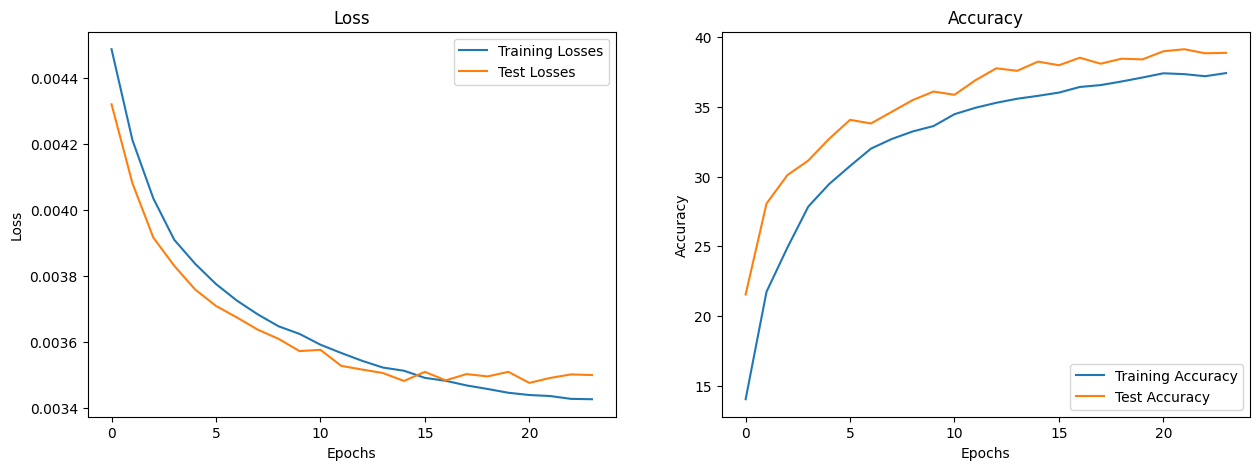

In [ ]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

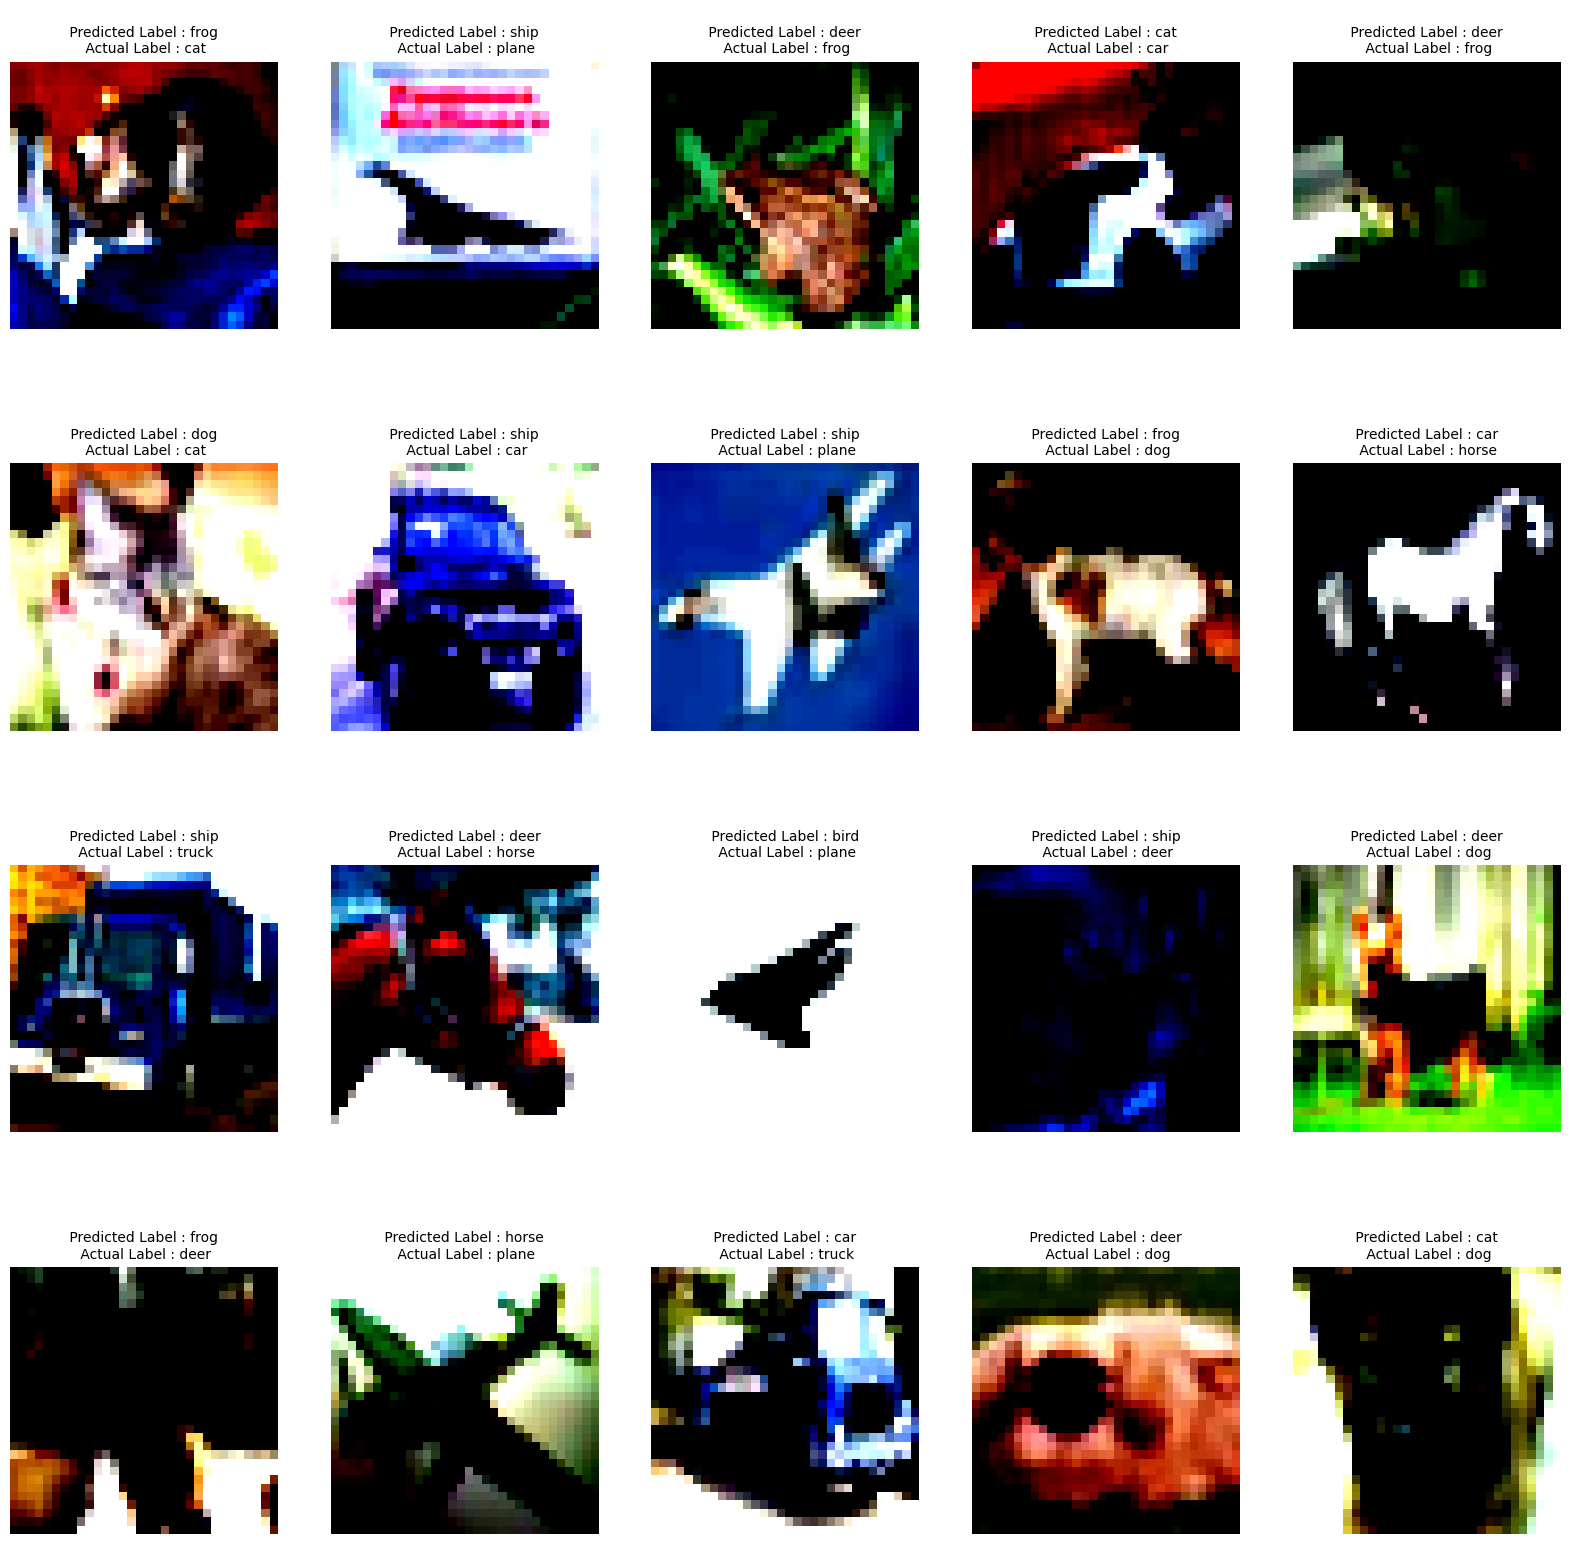

In [ ]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [ ]:
model_tr

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [50]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output):
              self.fmap_pool[key] = output.detach()

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out):
              self.grad_pool[key] = grad_out[0].detach()

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size during forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def generate_gradcam(misclassified_images, model, target_layers,device):
    images=[]
    labels=[]
    for i, (img, pred, correct) in enumerate(misclassified_images):
        images.append(img)
        labels.append(correct)
    
    model.eval()
    
    # map input to device
    images = torch.stack(images).to(device)
    
    # set up grad cam
    gcam = GradCAM(model, target_layers)
    
    # forward pass
    probs, ids = gcam.forward(images)
    
    # outputs agaist which to compute gradients
    ids_ = torch.LongTensor(labels).view(len(images),-1).to(device)
    
    # backward pass
    gcam.backward(ids=ids_)
    layers = []
    for i in range(len(target_layers)):
        target_layer = target_layers[i]
        print("Generating Grad-CAM @{}".format(target_layer))
        # Grad-CAM
        layers.append(gcam.generate(target_layer=target_layer))
        
    # remove hooks when done
    gcam.remove_hook()
    return layers, probs, ids

def plot_gradcam(gcam_layers, target_layers, class_names, image_size,predicted, misclassified_images,mean,std):

    images=[]
    labels=[]
    for i, (img, pred, correct) in enumerate(misclassified_images):
      images.append(img)
      labels.append(correct)

    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(30,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=14)
      plt.axis('off')

      for j in range(len(images)):
        image_cpu = images[j].cpu().numpy().astype(dtype=np.float32)
        for k in range(image_cpu.shape[0]):
          image_cpu[k] = image_cpu[k] * std[k] + mean[k]
        image_cpu = np.transpose(image_cpu, (1,2,0))
        img = np.uint8(255*image_cpu)
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f"actual: {class_names[labels[j]]} \npredicted: {class_names[predicted[j][0]]}", fontsize=12)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img)
          plt.axis('off')
          
        
        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')
        
        plt.axis('off')
    plt.show()

In [51]:
target_layers = ["patch_embedding.patcher"]
torch.autograd.set_detect_anomaly(True)

In [52]:
#from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @patch_embedding.patcher


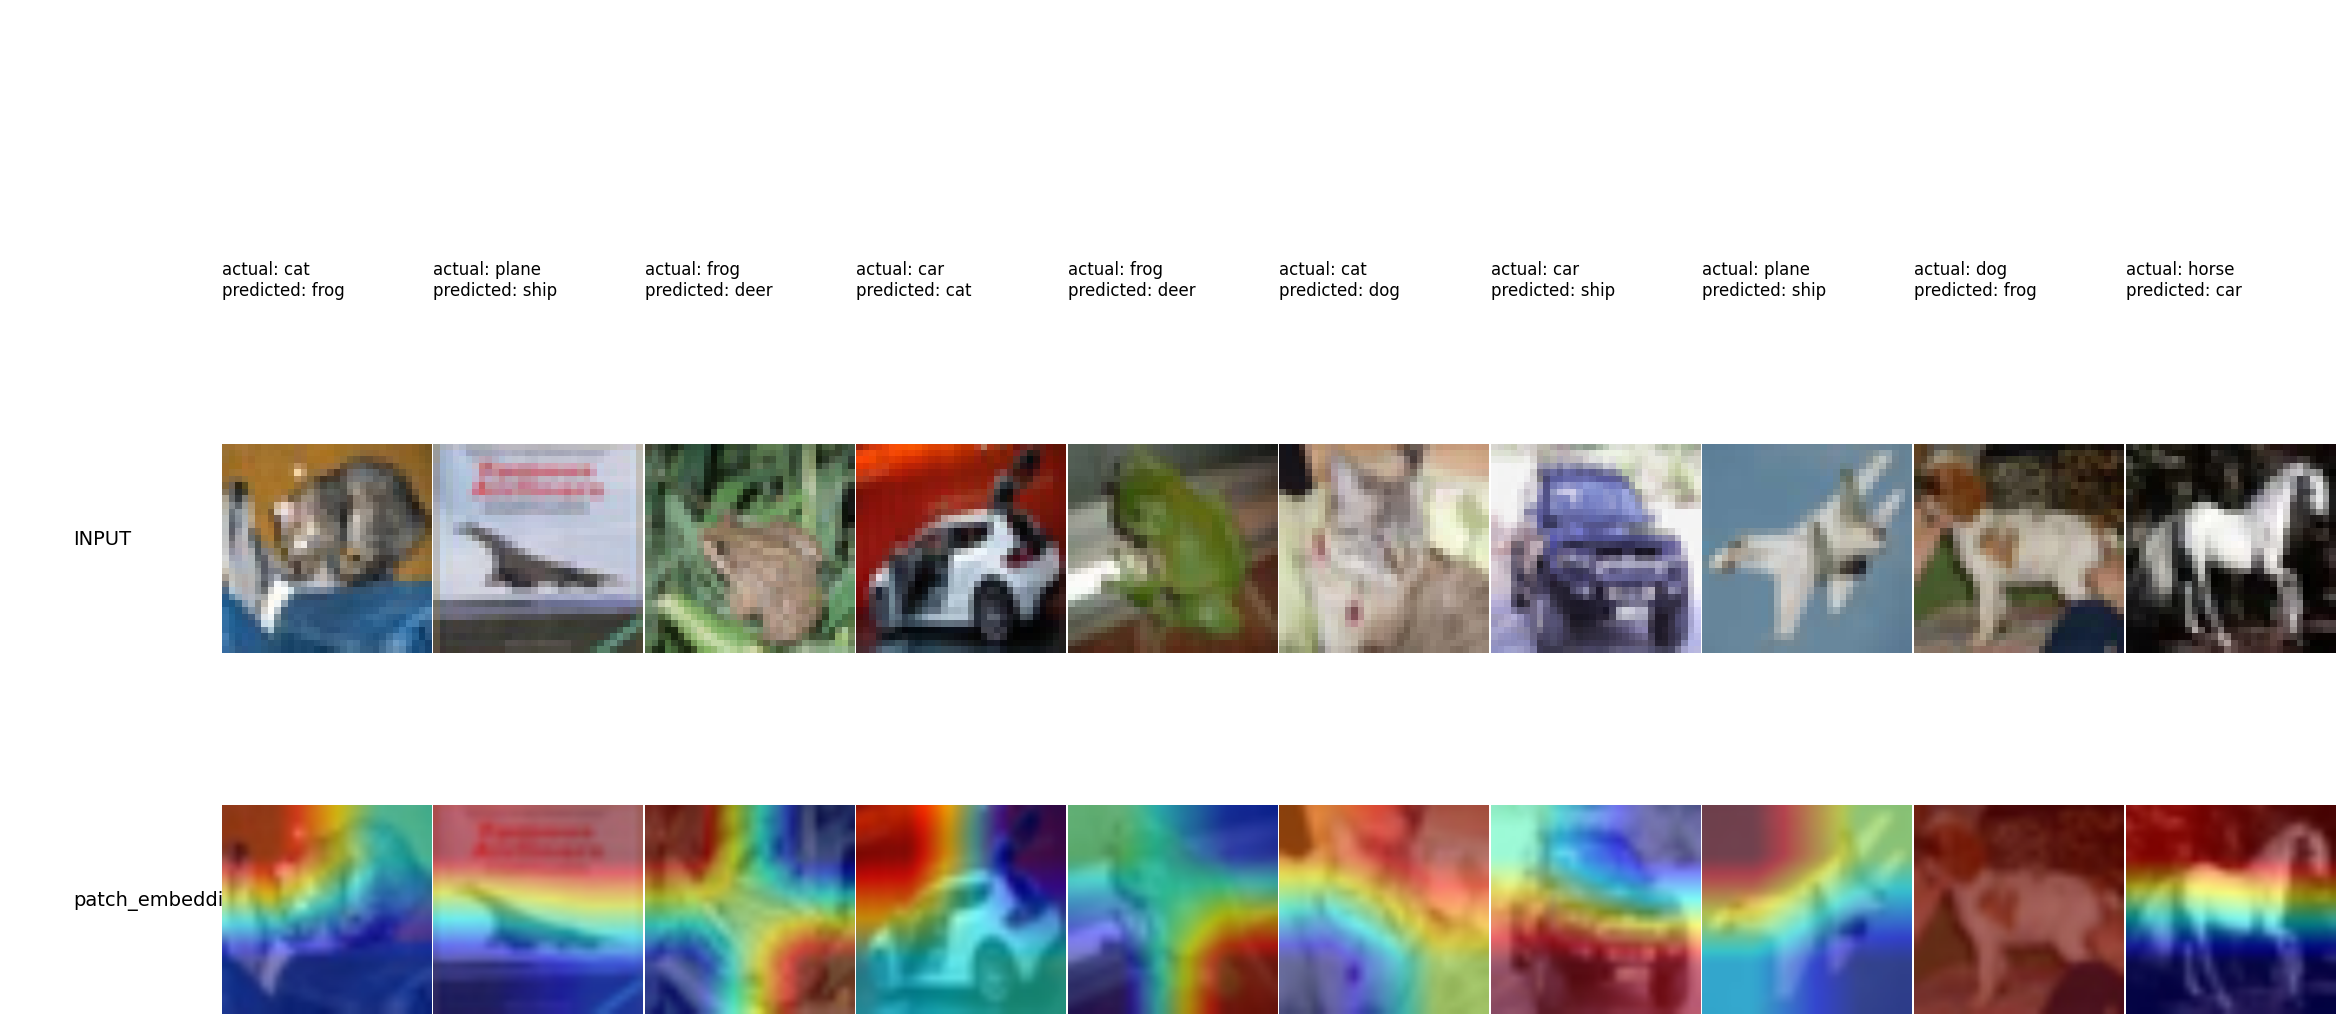

In [53]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [54]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @patch_embedding.patcher


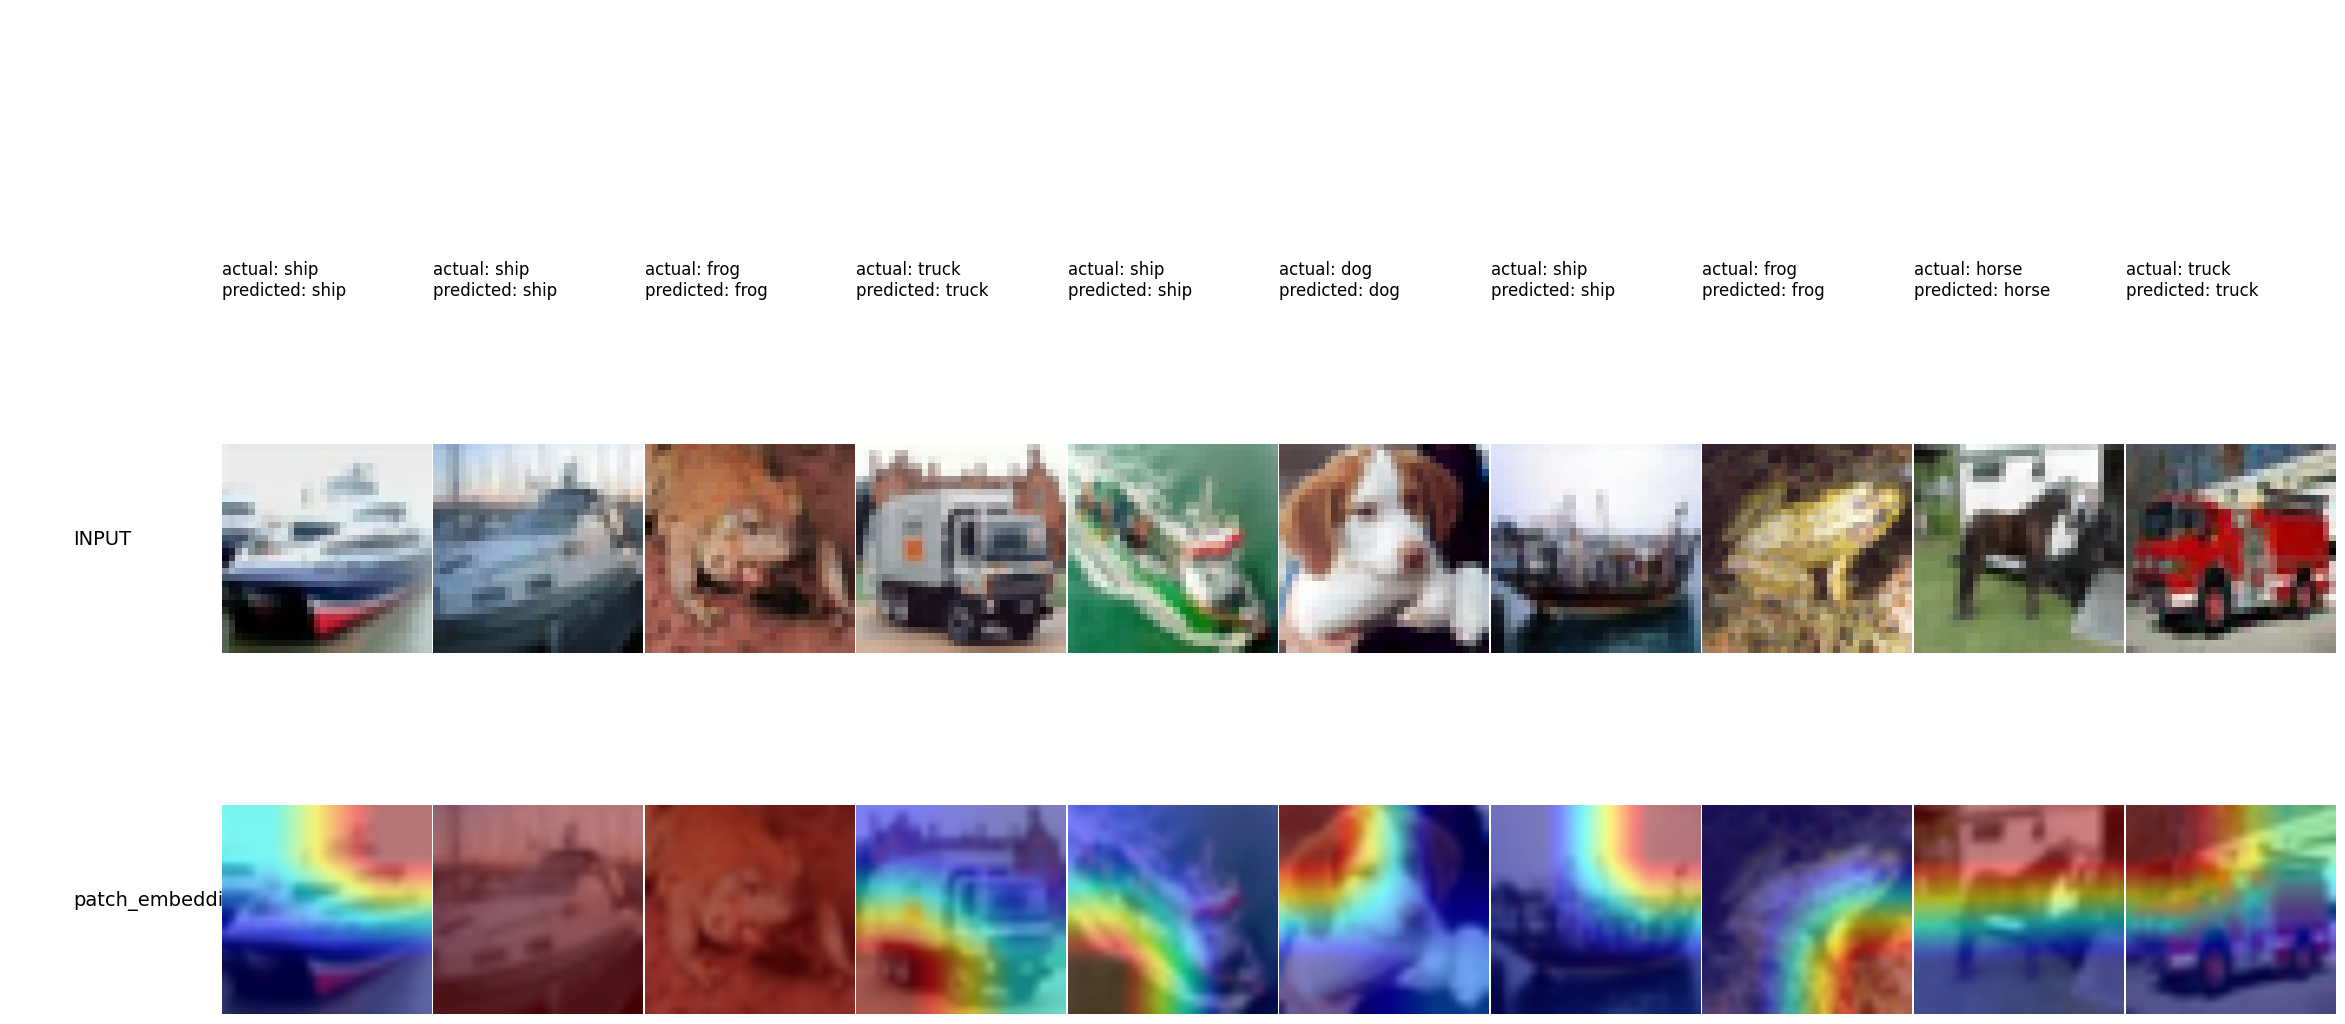

In [55]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)